In [1]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque

In [2]:
env = UnityEnvironment(file_name="Reacher_single")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUMBER_OF_AGENTS = states.shape[0]
STATE_SIZE = state_size
ACTION_SIZE = action_size

In [4]:
import sys

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F

def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

"""
From: https://github.com/pytorch/pytorch/issues/1959
There's an official LayerNorm implementation in pytorch now, but it hasn't been included in 
pip version yet. This is a temporary version
This slows down training by a bit
"""
class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)

        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

nn.LayerNorm = LayerNorm


class Actor(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Actor, self).__init__()
        self.action_space = action_space
        num_outputs = action_space.shape[0]

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)

        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

        self.mu = nn.Linear(hidden_size, num_outputs)
        self.mu.weight.data.mul_(0.1)
        self.mu.bias.data.mul_(0.1)

    def forward(self, inputs):
        x = inputs
        x = self.linear1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.ln2(x)
        x = F.relu(x)
        mu = F.tanh(self.mu(x))
        return mu

class Critic(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Critic, self).__init__()
        self.action_space = action_space
        num_outputs = action_space.shape[0]

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)

        self.linear2 = nn.Linear(hidden_size+num_outputs, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

        self.V = nn.Linear(hidden_size, 1)
        self.V.weight.data.mul_(0.1)
        self.V.bias.data.mul_(0.1)

    def forward(self, inputs, actions):
        x = inputs
        x = self.linear1(x)
        x = self.ln1(x)
        x = F.relu(x)

        x = torch.cat((x, actions), 1)
        x = self.linear2(x)
        x = self.ln2(x)
        x = F.relu(x)
        V = self.V(x)
        return V

class DDPG(object):
    def __init__(self, gamma, tau, hidden_size, num_inputs, action_space):

        self.num_inputs = num_inputs
        self.action_space = action_space

        self.actor = Actor(hidden_size, self.num_inputs, self.action_space)
        self.actor_target = Actor(hidden_size, self.num_inputs, self.action_space)
        self.actor_perturbed = Actor(hidden_size, self.num_inputs, self.action_space)
        self.actor_optim = Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(hidden_size, self.num_inputs, self.action_space)
        self.critic_target = Critic(hidden_size, self.num_inputs, self.action_space)
        self.critic_optim = Adam(self.critic.parameters(), lr=1e-3)

        self.gamma = gamma
        self.tau = tau

        hard_update(self.actor_target, self.actor)  # Make sure target is with the same weight
        hard_update(self.critic_target, self.critic)


    def select_action(self, state, action_noise=None, param_noise=None):
        self.actor.eval()
        if param_noise is not None: 
            mu = self.actor_perturbed((Variable(state)))
        else:
            mu = self.actor((Variable(state)))

        self.actor.train()
        mu = mu.data

        if action_noise is not None:
            mu += torch.Tensor(action_noise.noise())

        return mu.clamp(-1, 1)


    def update_parameters(self, batch):
        state_batch = Variable(torch.cat(batch.state))
        action_batch = Variable(torch.cat(batch.action))
        reward_batch = Variable(torch.cat(batch.reward))
        mask_batch = Variable(torch.cat(batch.mask))
        next_state_batch = Variable(torch.cat(batch.next_state))
        
        next_action_batch = self.actor_target(next_state_batch)
        next_state_action_values = self.critic_target(next_state_batch, next_action_batch)

        reward_batch = reward_batch.unsqueeze(1)
        mask_batch = mask_batch.unsqueeze(1)
        expected_state_action_batch = reward_batch + (self.gamma * mask_batch * next_state_action_values)

        self.critic_optim.zero_grad()

        state_action_batch = self.critic((state_batch), (action_batch))

        value_loss = F.mse_loss(state_action_batch, expected_state_action_batch)
        value_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()

        policy_loss = -self.critic((state_batch),self.actor((state_batch)))

        policy_loss = policy_loss.mean()
        policy_loss.backward()
        self.actor_optim.step()

        soft_update(self.actor_target, self.actor, self.tau)
        soft_update(self.critic_target, self.critic, self.tau)

        return value_loss.item(), policy_loss.item()

    def perturb_actor_parameters(self, param_noise):
        """Apply parameter noise to actor model, for exploration"""
        hard_update(self.actor_perturbed, self.actor)
        params = self.actor_perturbed.state_dict()
        for name in params:
            if 'ln' in name: 
                pass 
            param = params[name]
            param += torch.randn(param.shape) * param_noise.current_stddev

    def save_model(self, env_name, suffix="", actor_path=None, critic_path=None):
        if not os.path.exists('models/'):
            os.makedirs('models/')

        if actor_path is None:
            actor_path = "models/ddpg_actor_{}_{}".format(env_name, suffix) 
        if critic_path is None:
            critic_path = "models/ddpg_critic_{}_{}".format(env_name, suffix) 
        print('Saving models to {} and {}'.format(actor_path, critic_path))
        torch.save(self.actor.state_dict(), actor_path)
        torch.save(self.critic.state_dict(), critic_path)

    def load_model(self, actor_path, critic_path):
        print('Loading models from {} and {}'.format(actor_path, critic_path))
        if actor_path is not None:
            self.actor.load_state_dict(torch.load(actor_path))
        if critic_path is not None: 
            self.critic.load_state_dict(torch.load(critic_path))

In [6]:
import argparse
import math
from collections import namedtuple
from itertools import count
from tqdm import tqdm
from tensorboardX import SummaryWriter

import torch
from naf import NAF
from normalized_actions import NormalizedActions
from ounoise import OUNoise
from param_noise import AdaptiveParamNoiseSpec, ddpg_distance_metric
from replay_memory import ReplayMemory, Transition

parser = argparse.ArgumentParser(description='PyTorch REINFORCE example')
parser.add_argument('--algo', default='NAF',
                    help='algorithm to use: DDPG | NAF')
parser.add_argument('--env-name', default="HalfCheetah-v2",
                    help='name of the environment to run')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor for reward (default: 0.99)')
parser.add_argument('--tau', type=float, default=0.001, metavar='G',
                    help='discount factor for model (default: 0.001)')
parser.add_argument('--ou_noise', type=bool, default=True)
parser.add_argument('--param_noise', type=bool, default=False)
parser.add_argument('--noise_scale', type=float, default=0.3, metavar='G',
                    help='initial noise scale (default: 0.3)')
parser.add_argument('--final_noise_scale', type=float, default=0.3, metavar='G',
                    help='final noise scale (default: 0.3)')
parser.add_argument('--exploration_end', type=int, default=100, metavar='N',
                    help='number of episodes with noise (default: 100)')
parser.add_argument('--seed', type=int, default=4, metavar='N',
                    help='random seed (default: 4)')
parser.add_argument('--batch_size', type=int, default=128, metavar='N',
                    help='batch size (default: 128)')
parser.add_argument('--num_steps', type=int, default=1000, metavar='N',
                    help='max episode length (default: 1000)')
parser.add_argument('--num_episodes', type=int, default=1000, metavar='N',
                    help='number of episodes (default: 1000)')
parser.add_argument('--hidden_size', type=int, default=128, metavar='N',
                    help='number of episodes (default: 128)')
parser.add_argument('--updates_per_step', type=int, default=5, metavar='N',
                    help='model updates per simulator step (default: 5)')
parser.add_argument('--replay_size', type=int, default=1000000, metavar='N',
                    help='size of replay buffer (default: 1000000)')
args = parser.parse_args()

env = NormalizedActions(gym.make(args.env_name))

writer = SummaryWriter()

env.seed(args.seed)
torch.manual_seed(args.seed)
np.random.seed(args.seed)
if args.algo == "NAF":
    agent = NAF(args.gamma, args.tau, args.hidden_size,
                      env.observation_space.shape[0], env.action_space)
else:
    agent = DDPG(args.gamma, args.tau, args.hidden_size,
                      env.observation_space.shape[0], env.action_space)

memory = ReplayMemory(args.replay_size)

ounoise = OUNoise(env.action_space.shape[0]) if args.ou_noise else None
param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.05, 
    desired_action_stddev=args.noise_scale, adaptation_coefficient=1.05) if args.param_noise else None

rewards = []
total_numsteps = 0
updates = 0

for i_episode in range(args.num_episodes):
    state = torch.Tensor([env.reset()])

    if args.ou_noise: 
        ounoise.scale = (args.noise_scale - args.final_noise_scale) * max(0, args.exploration_end -
                                                                      i_episode) / args.exploration_end + args.final_noise_scale
        ounoise.reset()

    if args.param_noise and args.algo == "DDPG":
        agent.perturb_actor_parameters(param_noise)

    episode_reward = 0
    while True:
        action = agent.select_action(state, ounoise, param_noise)
        next_state, reward, done, _ = env.step(action.numpy()[0])
        total_numsteps += 1
        episode_reward += reward

        action = torch.Tensor(action)
        mask = torch.Tensor([not done])
        next_state = torch.Tensor([next_state])
        reward = torch.Tensor([reward])

        memory.push(state, action, mask, next_state, reward)

        state = next_state

        if len(memory) > args.batch_size:
            for _ in range(args.updates_per_step):
                transitions = memory.sample(args.batch_size)
                batch = Transition(*zip(*transitions))

                value_loss, policy_loss = agent.update_parameters(batch)

                writer.add_scalar('loss/value', value_loss, updates)
                writer.add_scalar('loss/policy', policy_loss, updates)

                updates += 1
        if done:
            break

    writer.add_scalar('reward/train', episode_reward, i_episode)

    # Update param_noise based on distance metric
    if args.param_noise:
        episode_transitions = memory.memory[memory.position-t:memory.position]
        states = torch.cat([transition[0] for transition in episode_transitions], 0)
        unperturbed_actions = agent.select_action(states, None, None)
        perturbed_actions = torch.cat([transition[1] for transition in episode_transitions], 0)

        ddpg_dist = ddpg_distance_metric(perturbed_actions.numpy(), unperturbed_actions.numpy())
        param_noise.adapt(ddpg_dist)

    rewards.append(episode_reward)
    if i_episode % 10 == 0:
        state = torch.Tensor([env.reset()])
        episode_reward = 0
        while True:
            action = agent.select_action(state)

            next_state, reward, done, _ = env.step(action.numpy()[0])
            episode_reward += reward

            next_state = torch.Tensor([next_state])

            state = next_state
            if done:
                break

        writer.add_scalar('reward/test', episode_reward, i_episode)

        rewards.append(episode_reward)
        print("Episode: {}, total numsteps: {}, reward: {}, average reward: {}".format(i_episode, total_numsteps, rewards[-1], np.mean(rewards[-10:])))
    
env.close()

ModuleNotFoundError: No module named 'ddpg'

In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples.
    
    Attributes:
        action_size (int): dimension of each action
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        seed (int): random seed 
    """

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object."""
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

In [5]:
class Actor(nn.Module):

    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(input_size, input_size * 2)
        self.fc2 = nn.Linear(input_size * 2, input_size * 2)
        self.fc3 = nn.Linear(input_size * 2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
class Critic(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()
        
        input_size = input_size + output_size
        self.fc1 = nn.Linear(input_size, input_size * 2)
        self.fc2 = nn.Linear(input_size * 2, input_size * 2)
        self.fc3 = nn.Linear(input_size * 2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

    
class AdaptiveParamNoiseSpec(object):
    def __init__(self, initial_stddev=0.1, desired_action_stddev=0.1, adoption_coefficient=1.01):
        self.initial_stddev = initial_stddev
        self.desired_action_stddev = desired_action_stddev
        self.adoption_coefficient = adoption_coefficient

        self.current_stddev = initial_stddev

    def adapt(self, distance):
        if distance > self.desired_action_stddev:
            # Decrease stddev.
            self.current_stddev /= self.adoption_coefficient
        else:
            # Increase stddev.
            self.current_stddev *= self.adoption_coefficient

    def get_stats(self):
        stats = {
            'param_noise_stddev': self.current_stddev,
        }
        return stats

    def __repr__(self):
        fmt = 'AdaptiveParamNoiseSpec(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
        return fmt.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)
# run your own policy!
# policy=Policy().to(device)
# policy = Policy(STATE_SIZE, ACTION_SIZE).to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
# actor_optimizer = optim.Adam(policy.parameters(), lr=2e-4)

In [6]:
actor = Actor(STATE_SIZE, ACTION_SIZE).to(device)
actor_perturbed = Actor(STATE_SIZE, ACTION_SIZE).to(device)
critic = Critic(STATE_SIZE, ACTION_SIZE).to(device)
actor_target = Actor(STATE_SIZE, ACTION_SIZE).to(device)
critic_target = Critic(STATE_SIZE, ACTION_SIZE).to(device)

hard_update(actor_target, actor)
hard_update(critic_target, critic)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)
buffer = ReplayBuffer(ACTION_SIZE, 10000, 32, 0)

param_noise = AdaptiveParamNoiseSpec()

rr = []
for e in range(1, 100 + 1):
    if e % 10 == 0:
        clear_output(True)
        print(f"Iteration {e}")
        
    hard_update(actor_perturbed, actor)
    params = actor_perturbed.state_dict()
    for name in params:
        if 'ln' in name: 
            pass 
        param = params[name]
        param += torch.randn(param.shape) * param_noise.current_stddev
        
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations
    
    r = []
    for t in range(500):
        state_tensor = torch.tensor(state).float()
        raw_action = actor(state_tensor).squeeze().detach().numpy()
        action = np.clip(raw_action, -1, 1)
                    
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        done = 1 if env_info.local_done else 0
        reward = env_info.rewards
        r.append(sum(reward))
        
        buffer.add(state, raw_action, reward, next_state, done)
        if len(buffer) >= 64:
            states, actions, rewards, next_states, dones = buffer.sample()
            y = rewards + 0.9999 * critic_target(torch.cat((next_states, actor_target(next_states)), 1))
            concat = torch.cat((states.float(), actions.float()), 1)
            L = torch.mean(torch.sum(y - critic(concat)))

            critic_optimizer.zero_grad()
            L.backward()
            critic_optimizer.step()
            
            J = - torch.mean(torch.sum(critic(concat)))
            actor_optimizer.zero_grad()
            J.backward()
            actor_optimizer.step()
            
            soft_update(actor_target, actor, 0.9)
            soft_update(critic_target, critic, 0.9)
    param_noise.adapt(max(30 - sum(r), 0) / 300.0)
    rr.append(sum(r))
    print(sum(r))
            

Iteration 50
0.0
0.6999999843537807


KeyboardInterrupt: 

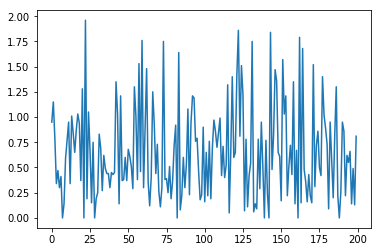

In [9]:
import matplotlib.pyplot as plt

plt.plot(rr)
plt.show()

In [ ]:
from copy import deepcopy
from IPython.display import clear_output

iters = 500
tmax =  300
gamma = 0.99
epochs = 2
epsilon = 0.1
r = []
# old_policy = deepcopy(policy)

for i in range(iters):
    if i % 10 == 0:
        clear_output(True)
        print(f"Iteration {i}")
        if len(r) > 100:
            print(f"Last 100 rewards average {sum(r[-100:])/len(r[-100:])}")
    
    all_rewards = []
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations
    all_states = []
    all_actions = []
    
    for t in range(tmax):
        state_tensor = torch.tensor(state).float()
        raw_actions = policy(state_tensor).squeeze().detach().numpy()
        actions = np.clip(raw_actions, -1, 1)

        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        dones = env_info.local_done  
        rewards = env_info.rewards
        
        all_rewards.append(rewards)
        all_states.append(state)
        all_actions.append(raw_actions)
        
        state = next_states
        if True in dones:
            break
    
    all_rewards = np.array(all_rewards)
    r.append(np.sum(all_rewards))
    discounts = gamma ** np.arange(all_rewards.shape[0])
    discounted_rewards = all_rewards * discounts.reshape((tmax, 1))
    future_rewards = discounted_rewards[::-1].cumsum(axis=0)[::-1]
    future_rewards = future_rewards.reshape((tmax, NUMBER_OF_AGENTS, 1))
    
    mean = np.mean(future_rewards, axis=1)
    std = np.std(future_rewards, axis=1) + 1.0e-10
    rewards_normalized = (future_rewards - mean[:,np.newaxis])/std[:,np.newaxis]
    
    actions_tensor = torch.tensor(all_actions)
    rewards_tensor = torch.tensor(rewards_normalized.copy(), dtype=torch.float)
    for e in range(epochs):
#         ratio = policy(torch.tensor(all_states).float()).squeeze().detach().numpy() /
        new_policy = policy(torch.tensor(all_states).float())
        ratio = (policy(torch.tensor(all_states).float()) / actions_tensor)
        ratio = ratio * rewards_tensor
        ratio = torch.mean(ratio)
        clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
        
        L = torch.min(ratio, clipped)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
        
        
    

In [ ]:
import matplotlib.pyplot as plt

plt.plot(r)
plt.show()

In [ ]:
def collect_trajectories(env, policy, number_of_agents, tmax=200, nrand=5):
    
    raw_action_list = []
    state_list=[]
    reward_list=[]
    action_list=[]

    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations
    
    # perform nrand random steps
    for _ in range(nrand):
        raw_actions = np.random.randn(NUMBER_OF_AGENTS, ACTION_SIZE)
        actions = np.clip(raw_actions, -1, 1)

        env_info = env.step(actions)[brain_name]
        states = env_info.vector_observations
        rewards = env_info.rewards
        
    for t in range(tmax):
        state_tensor = torch.tensor(states).float()
        raw_actions = policy(state_tensor).squeeze().cpu().detach().numpy()
        actions = np.clip(raw_actions, -1, 1)
        
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        dones = env_info.local_done  
        rewards = env_info.rewards


        raw_action_list.append(raw_actions)
        state_list.append(states)
        reward_list.append(rewards)
        action_list.append(actions)
        
        states = next_states
        
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if True in dones:
            break

    # return pi_theta, states, actions, rewards, probability
    return raw_actions, state_list, action_list, reward_list

In [ ]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    states = torch.tensor(states, dtype=torch.float, device=device)
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized[:, :, np.newaxis], dtype=torch.float, device=device)
    
    new_probs = policy.forward(states)

    division = new_probs / old_probs
    p = torch.min(new_probs / old_probs, torch.clamp(new_probs / old_probs, 1 - epsilon, 1 + epsilon)) * rewards 
    entropy = -(new_probs*torch.log(old_probs+1.e-10) + (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
#     return torch.mean(p + beta*entropy)
    return torch.mean(p)

In [ ]:

# envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

# discount_rate = .99
epsilon = 0.1
beta = .01
# tmax = 320
# SGD_epoch = 4

# # keep track of progress
mean_rewards = []

for e in range(100):
    raw_actions, states, actions, rewards = collect_trajectories(env, policy, NUMBER_OF_AGENTS)
    total_rewards = np.sum(rewards, axis=0)
    L = - clipped_surrogate(policy, raw_actions, states, actions, rewards, epsilon=epsilon, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
    
    epsilon*=.999
    beta*=.995
    
    mean_rewards.append(np.mean(total_rewards))

    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)



#     # gradient ascent step
#     for _ in range(SGD_epoch):
        
#         # uncomment to utilize your own clipped function!
#         L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

# #         L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
# #                                           epsilon=epsilon, beta=beta)
#         optimizer.zero_grad()
#         L.backward()
#         optimizer.step()
#         del L
    
#     # the clipping parameter reduces as time goes on
#     epsilon*=.999
    
#     # the regulation term also reduces
#     # this reduces exploration in later runs
#     beta*=.995
    
#     # get the average reward of the parallel environments
#     mean_rewards.append(np.mean(total_rewards))
    
#     # display some progress every 20 iterations
#     if (e+1)%20 ==0 :
#         print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
#         print(total_rewards)
        
#     # update progress widget bar
#     timer.update(e+1)
    
# timer.finish()

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [ ]:
env.close()